The use of Claude and Copilot was used to help code up some of these sections. I have reviwed the code and ensured it is doing what is intended.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

##### Bike Sharing Data Analysis: Neural Networks & ARIMA

##### Question 1: Data Loading and Exploration

In [72]:

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(2)

print("\n" + "="*80)
print("QUESTION 1: Data Loading and Exploration")
print("="*80)

# Load the dataset
df_hour = pd.read_csv('../../datasets/hour.csv')

# Display first 10 rows
print("\nFirst 10 rows of the dataset:")
print(df_hour.head(10))

# Basic statistics
print("\nBasic Statistics:")
print(df_hour.describe())

# Check for missing values
print("\nMissing Values:")
print(df_hour.isnull().sum())

# Shape and data types
print(f"\nDataset Shape: {df_hour.shape}")
print("\nData Types:")
print(df_hour.dtypes)


QUESTION 1: Data Loading and Exploration

First 10 rows of the dataset:
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   
6        7  2011-01-01       1   0     1   6        0        6           0   
7        8  2011-01-01       1   0     1   7        0        6           0   
8        9  2011-01-01       1   0     1   8        0        6           0   
9       10  2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cn

##### Question 2: Data Preprocessing

In [73]:
# Drop unnecessary columns
df_processed = df_hour.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Separate features and target
X = df_processed.drop('cnt', axis=1)
y = df_processed['cnt']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (13903, 12)
X_test shape: (3476, 12)
y_train shape: (13903,)
y_test shape: (3476,)


##### Question 3: Feature Engineering and Normalization

In [74]:
# Create cyclical features for hour
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hr'] / 24)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hr'] / 24)
X_test['hour_sin'] = np.sin(2 * np.pi * X_test['hr'] / 24)
X_test['hour_cos'] = np.cos(2 * np.pi * X_test['hr'] / 24)

# Standardize continuous features
continuous_features = ['temp', 'atemp', 'hum', 'windspeed']
scaler = StandardScaler() # Default for StandardScaler uses mean=true and std=true
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# One-hot encode categorical features
categorical_features = ['season', 'weathersit', 'mnth', 'weekday']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=False)

# Ensure train and test have same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Convert all columns to float to avoid object dtype issues
X_train_encoded = X_train_encoded.astype(np.float32)
X_test_encoded = X_test_encoded.astype(np.float32)

print(f"\nFeatures after engineering: {X_train_encoded.shape[1]}")
print(f"Feature names: {list(X_train_encoded.columns)}")
print(f"Data types after conversion: {X_train_encoded.dtypes.unique()}")


Features after engineering: 37
Feature names: ['yr', 'hr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'hour_sin', 'hour_cos', 'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
Data types after conversion: [dtype('float32')]


##### Question 4: PyTorch Dataset and DataLoader

In [75]:
print("\n" + "="*80)
print("QUESTION 4: PyTorch Dataset and DataLoader")
print("="*80)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_encoded.values)
X_test_tensor = torch.FloatTensor(X_test_encoded.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")
print(f"Input features: {X_train_tensor.shape[1]}")



QUESTION 4: PyTorch Dataset and DataLoader

Training batches: 218
Testing batches: 55
Input features: 37


##### Question 5: Neural Network Architecture Design

In [76]:
## Old Naive NN architecture
# class BikeRentalNN(nn.Module):
#     def __init__(self, input_size):
#         super(BikeRentalNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, 32)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(32, 16)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(16, 4)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(4, 1)
    
#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.relu2(self.fc2(x))
#         x = self.relu3(self.fc3(x))
#         x = self.fc4(x)
#         return x


# This architecutre narrowed down too quickly and I don't think it captured the seasonality to well so I made new architecture.

class BikeRentalNN(nn.Module):
    def __init__(self, input_size):
        super(BikeRentalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x
    
# Initialize model
input_size = X_train_tensor.shape[1]
model = BikeRentalNN(input_size)

print("\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal Parameters: {total_params}")


Model Architecture:
BikeRentalNN(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Total Parameters: 15681


##### Question 6: Training Setup

In [77]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# i have two laptops and one has a gpu so this is nice.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nDevice: {device}")
print(f"Loss Function: Mean Squared Error")
print(f"Optimizer: Adam (lr=0.001)")


Device: cpu
Loss Function: Mean Squared Error
Optimizer: Adam (lr=0.001)


##### Question 7: Model Training with Validation


Training the model...

Epoch [10/100], Loss: 6723.2445, MAE: 55.3779
Epoch [20/100], Loss: 5183.9770, MAE: 48.2419
Epoch [30/100], Loss: 4884.9828, MAE: 46.9513
Epoch [40/100], Loss: 4709.5694, MAE: 45.4529
Epoch [50/100], Loss: 4722.5976, MAE: 45.6418
Epoch [60/100], Loss: 4583.4204, MAE: 45.4059
Epoch [70/100], Loss: 4494.7945, MAE: 45.1327
Epoch [80/100], Loss: 4472.7129, MAE: 45.0117
Epoch [90/100], Loss: 4548.5424, MAE: 44.6638
Epoch [100/100], Loss: 4441.0733, MAE: 44.5916

Training completed!


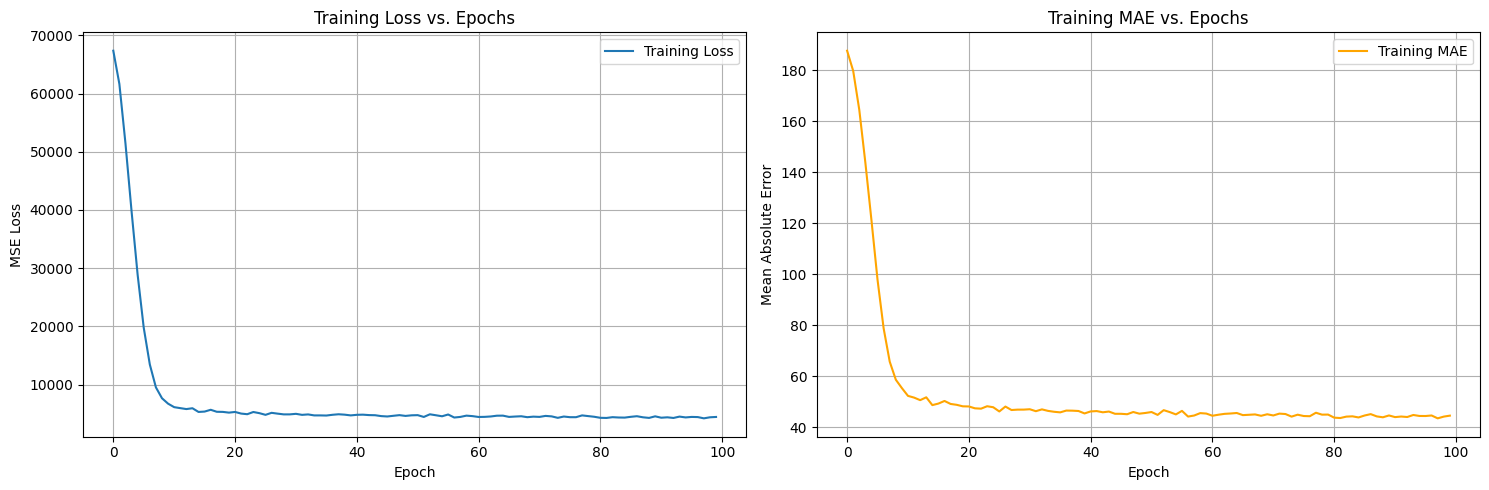

In [78]:
# Training loop
num_epochs = 100
train_losses = []
train_maes = []
val_losses = []
val_maes = []

print("\nTraining the model...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    epoch_mae = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_mae += mean_absolute_error(y_batch.cpu().detach().numpy(), 
                                         outputs.cpu().detach().numpy())
    
    avg_loss = epoch_loss / len(train_loader)
    avg_mae = epoch_mae / len(train_loader)
    train_losses.append(avg_loss)
    train_maes.append(avg_mae)
    
    # Validation phase (every 5 epochs)
    if (epoch + 1) % 5 == 0:
        model.eval()
        val_loss = 0
        val_mae = 0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
                val_mae += mean_absolute_error(y_batch.cpu().numpy(), 
                                               outputs.cpu().numpy())
        
        val_losses.append(val_loss / len(test_loader))
        val_maes.append(val_mae / len(test_loader))
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}")

print("\nTraining completed!")

# Plot training metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Loss vs. Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(train_maes, label='Training MAE', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('Training MAE vs. Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Looks like 10 epochs were good enough for this NN architecture.

##### Question 8: Model Evaluation and Analysis


Test Metrics:
Test MSE: 3402.6157
Test MAE: 36.1279
Test R² Score: 0.8952


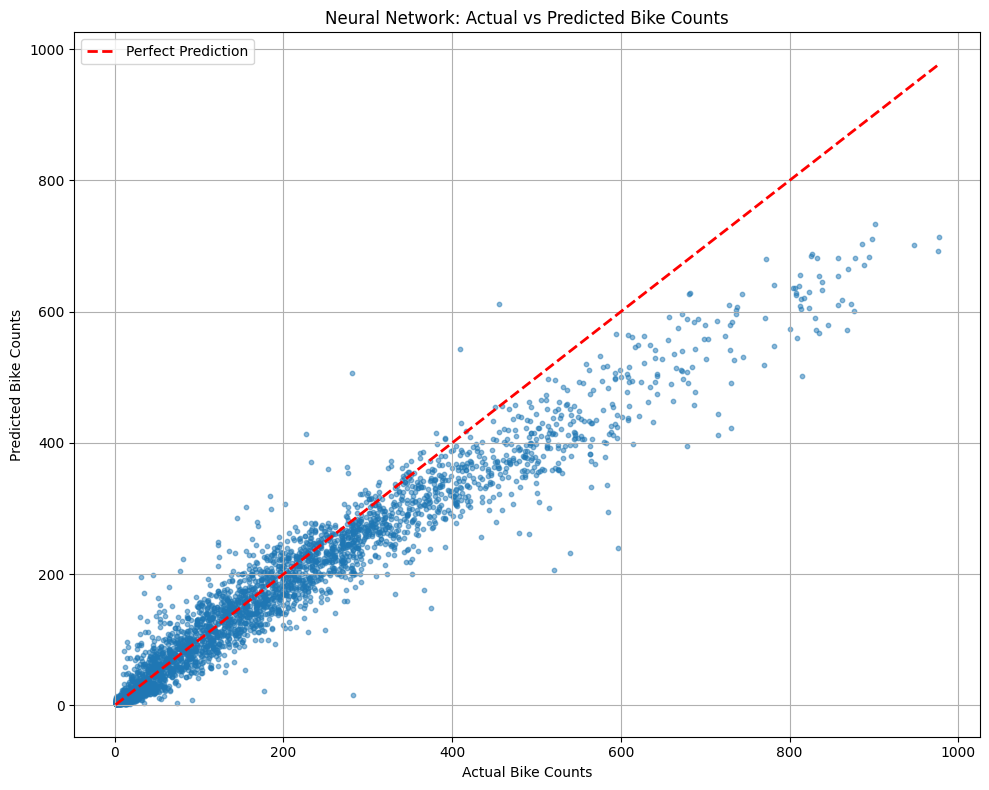


--------------------------------------------------------------------------------
ANALYSIS:
--------------------------------------------------------------------------------

The suggested NN architecture did quite poorly, Test MSE: 60419.5547, Test MAE: 171.5758, Test R² Score: -0.8614.
After playing around with the NN layers I was able to improve the NN performance substantially.
Notice how the mean error scores are much lower,
and most importantly the R^2 score isn't negative anymore.



In [79]:
# Evaluate on test set
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_pred_list.append(outputs.cpu().numpy())
        y_true_list.append(y_batch.numpy())

y_pred = np.concatenate(y_pred_list).flatten()
y_true = np.concatenate(y_true_list).flatten()

# Calculate metrics
test_mse = mean_squared_error(y_true, y_pred)
test_mae = mean_absolute_error(y_true, y_pred)
test_r2 = r2_score(y_true, y_pred)

print(f"\nTest Metrics:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Bike Counts')
plt.ylabel('Predicted Bike Counts')
plt.title('Neural Network: Actual vs Predicted Bike Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("ANALYSIS:")
print("-"*80)
print("""
The suggested NN architecture did quite poorly, Test MSE: 60419.5547, Test MAE: 171.5758, Test R² Score: -0.8614.
After playing around with the NN layers I was able to improve the NN performance substantially.
Notice how the mean error scores are much lower,
and most importantly the R^2 score isn't negative anymore.
""")

##### Part 2: Time Series w/ ARIMA

##### Question 9: Time Series Data Preparation and EDA

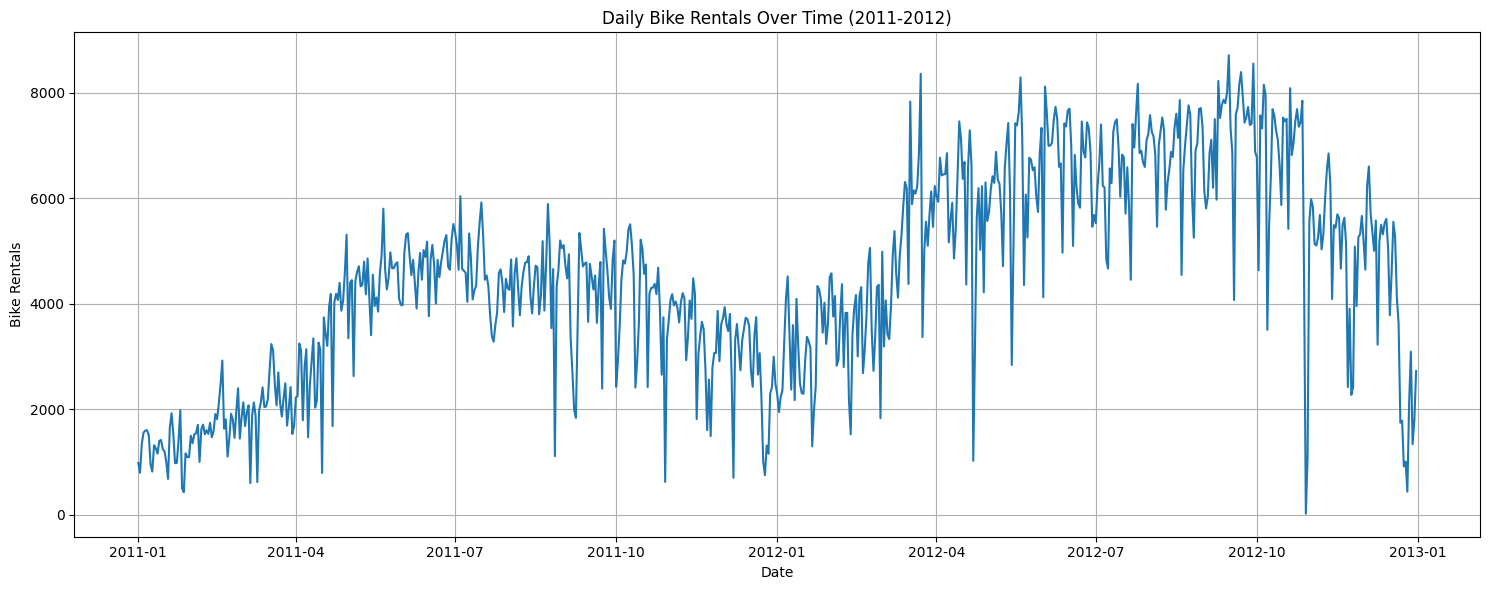

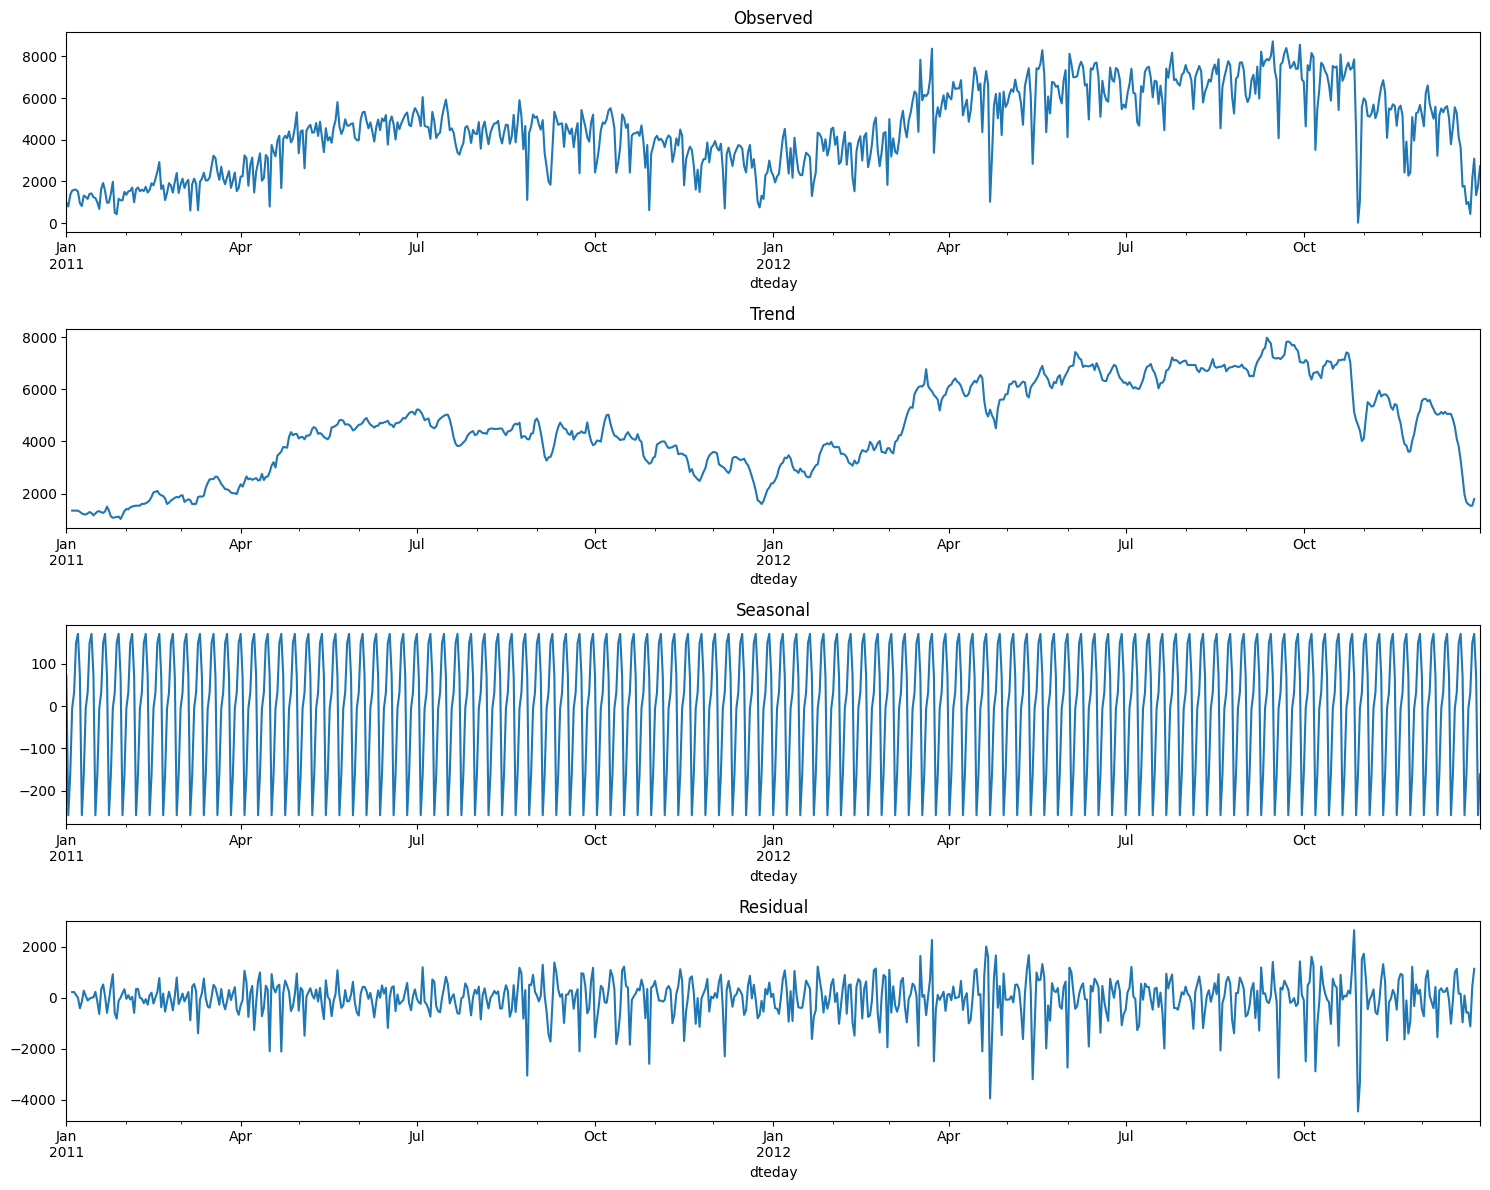


--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test (Original Series):
--------------------------------------------------------------------------------
ADF Statistic: -1.8774
p-value: 0.3427
Critical Values:
  1%: -3.4395
  5%: -2.8656
  10%: -2.5689

The series is NOT stationary (p-value > 0.05)
Applying first-order differencing...

--------------------------------------------------------------------------------
Augmented Dickey-Fuller Test (Differenced Series):
--------------------------------------------------------------------------------
ADF Statistic: -11.7788
p-value: 0.0000

The differenced series IS stationary (p-value <= 0.05)

--------------------------------------------------------------------------------
OBSERVATIONS:
--------------------------------------------------------------------------------

SEASONAL PATTERNS:
- At first glance it is easy to see that there was an increase in bike rentals from 2011 - 2012
- U

In [80]:
# Load daily data
df_day = pd.read_csv('../../datasets/day.csv')

# Convert to datetime and set as index
df_day['dteday'] = pd.to_datetime(df_day['dteday'])
df_day.set_index('dteday', inplace=True)

# Create time series
ts_cnt = df_day['cnt']

# Plot time series
plt.figure(figsize=(15, 6))
plt.plot(ts_cnt)
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.title('Daily Bike Rentals Over Time (2011-2012)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series decomposition
decomposition = seasonal_decompose(ts_cnt, model='additive', period=7) # 7 chosen for 1 week, or 7 days

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

# ADF test for stationarity
print("\n" + "-"*80)
print("Augmented Dickey-Fuller Test (Original Series):")
print("-"*80)
adf_result = adfuller(ts_cnt)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result[1] > 0.05:
    print("\nThe series is NOT stationary (p-value > 0.05)")
    print("Applying first-order differencing...")
    
    ts_diff = ts_cnt.diff().dropna()
    
    print("\n" + "-"*80)
    print("Augmented Dickey-Fuller Test (Differenced Series):")
    print("-"*80)
    adf_result_diff = adfuller(ts_diff)
    print(f"ADF Statistic: {adf_result_diff[0]:.4f}")
    print(f"p-value: {adf_result_diff[1]:.4f}")
    
    if adf_result_diff[1] <= 0.05:
        print("\nThe differenced series IS stationary (p-value <= 0.05)")
else:
    print("\nThe series IS stationary (p-value <= 0.05)")

print("\n" + "-"*80)
print("OBSERVATIONS:")
print("-"*80)
print("""
SEASONAL PATTERNS:
- At first glance it is easy to see that there was an increase in bike rentals from 2011 - 2012
- Upon closer inspection there is also an easy to spot pattern where bike rentals spike due to the warmer months and recedes during colder months
- This shows that strong weekly seasonality is evident with regular 7-day cycles
      
ADF TEST RESULTS:
- The original data showed non-stationarity with a p-value > 0.05
- After first-order differencing, the series became stationary
- This means d in our ARIMA model should be 1 for higher at least.
""")

##### Question 10: ARIMA Modeling and Forecasting


Training set size: 717
Testing set size: 14


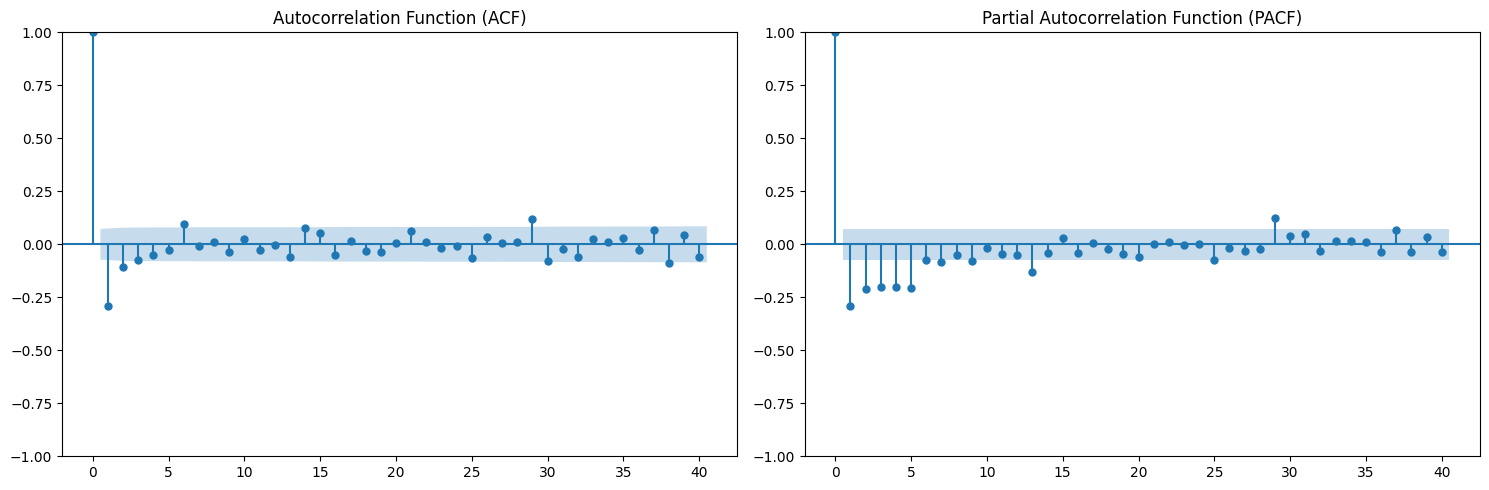


--------------------------------------------------------------------------------
ARIMA Parameter Selection:
--------------------------------------------------------------------------------

Based on ACF and PACF plots:
- d = 1 (confirmed by ADF test requiring one differencing)
- p = 2 or 3 (PACF cuts off after lag 2-3, suggesting AR terms)
- q = 2 or 3 (ACF shows gradual decay, suggesting MA terms)

Starting with ARIMA(2, 1, 2) as a baseline model.


Fitting ARIMA(2, 1, 2) model...

--------------------------------------------------------------------------------
ARIMA Model Summary:
--------------------------------------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  717
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5892.666
Date:                Thu, 04 Dec 2025   AIC                          11795.332
Time:       

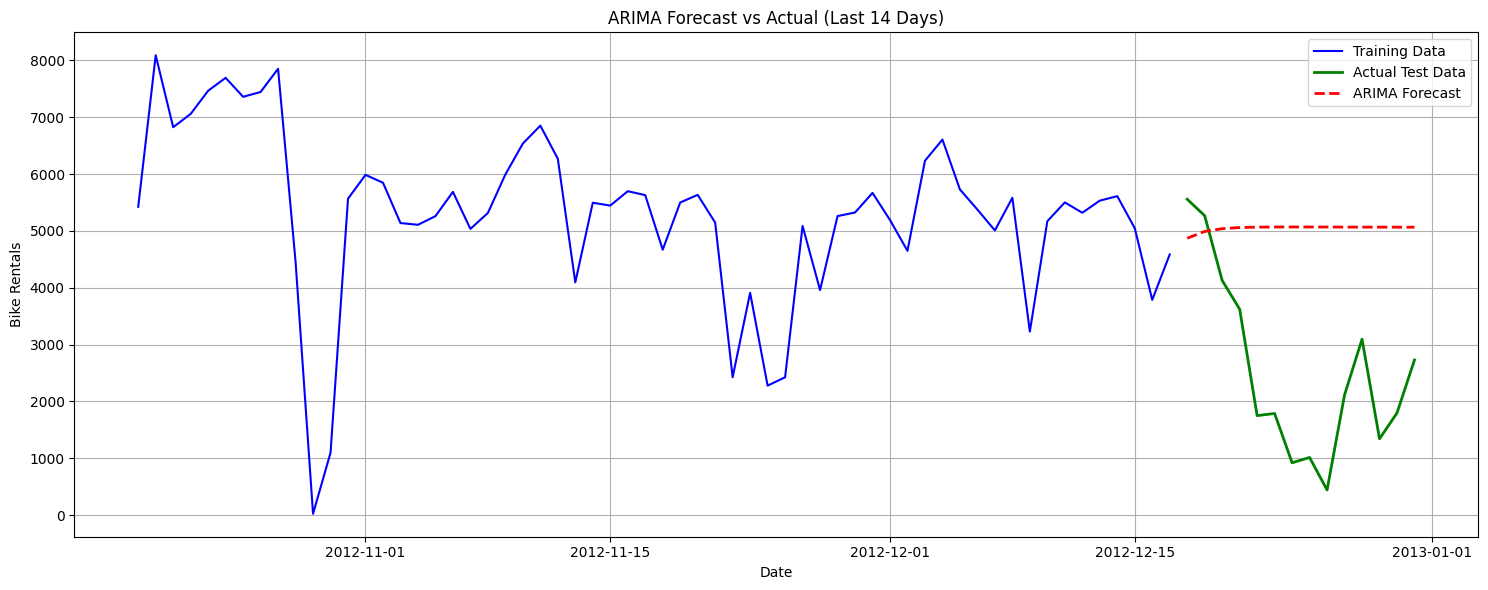


ARIMA Model Evaluation:
ARIMA MAE: 2642.2918
ARIMA RMSE: 2962.7155

COMPARISON: Neural Network vs ARIMA
Neural Network MAE: 36.1279
ARIMA MAE: 2642.2918

Neural Network performed better: Yes


In [81]:
# Split data: last 14 days for testing
train_size = len(ts_cnt) - 14
ts_train = ts_cnt[:train_size]
ts_test = ts_cnt[train_size:]

print(f"\nTraining set size: {len(ts_train)}")
print(f"Testing set size: {len(ts_test)}")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ts_cnt.diff().dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(ts_cnt.diff().dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("ARIMA Parameter Selection:")
print("-"*80)
print("""
Based on ACF and PACF plots:
- d = 1 (confirmed by ADF test requiring one differencing)
- p = 2 or 3 (PACF cuts off after lag 2-3, suggesting AR terms)
- q = 2 or 3 (ACF shows gradual decay, suggesting MA terms)

Starting with ARIMA(2, 1, 2) as a baseline model.
""")

# Fit ARIMA model
print("\nFitting ARIMA(2, 1, 2) model...")
arima_model = ARIMA(ts_train, order=(2, 1, 2))
arima_fitted = arima_model.fit()

print("\n" + "-"*80)
print("ARIMA Model Summary:")
print("-"*80)
print(arima_fitted.summary())

# Make predictions
arima_forecast = arima_fitted.forecast(steps=14)

# Plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(ts_train.index[-60:], ts_train[-60:], label='Training Data', color='blue')
plt.plot(ts_test.index, ts_test, label='Actual Test Data', color='green', linewidth=2)
plt.plot(ts_test.index, arima_forecast, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.title('ARIMA Forecast vs Actual (Last 14 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate ARIMA metrics
arima_mae = mean_absolute_error(ts_test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(ts_test, arima_forecast))

print("\n" + "="*80)
print("ARIMA Model Evaluation:")
print("="*80)
print(f"ARIMA MAE: {arima_mae:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")

print("\n" + "="*80)
print("COMPARISON: Neural Network vs ARIMA")
print("="*80)
print(f"Neural Network MAE: {test_mae:.4f}")
print(f"ARIMA MAE: {arima_mae:.4f}")
print(f"\nNeural Network performed better: {'Yes' if test_mae < arima_mae else 'No'}")


ARIMA is good for inference but still falls short even when compared with the naive NN architecture; Test MSE: 60419.5547, Test MAE: 171.5758.
When compared to the refined NN architecture it really blows ARIMA out of the water.
There is seasonality in this data so an SARIMAX model will be explored with the use of exogenous variables to try to yield better scores.
Also, the ARIMA forecast is rather flat, and it doesn't follow the trends at all making me believe we need seasonality in our ARIMA model.


Training set size: 717
Testing set size: 14


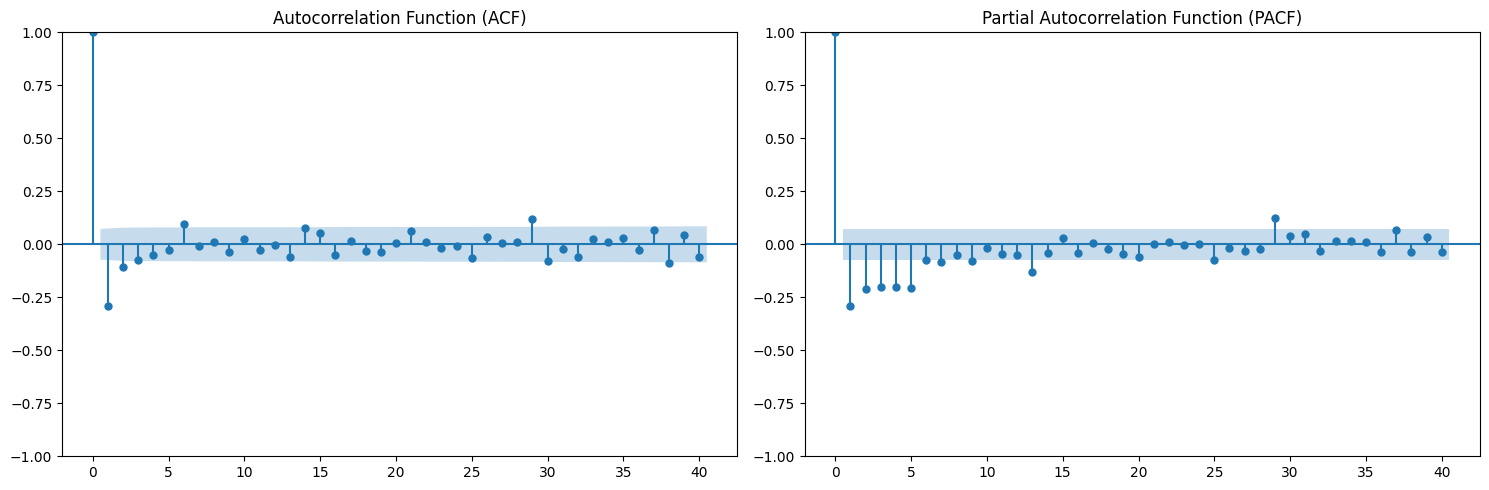


--------------------------------------------------------------------------------
SARIMAX Parameter Selection:
--------------------------------------------------------------------------------

Using SARIMAX(2, 1, 2)(1, 1, 1, 7) with exogenous variables:
- (p, d, q) = (2, 1, 2): Non-seasonal ARIMA components
- (P, D, Q, s) = (1, 1, 1, 7): Seasonal components with weekly period
- Exogenous variables: temp, humidity, windspeed, workingday, holiday, weather


Fitting SARIMAX model...

SARIMAX Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                  717
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -5684.119
Date:                             Thu, 04 Dec 2025   AIC                          11394.238
Time:                                     11:43:19   BIC                          11453.384
Sample:                        

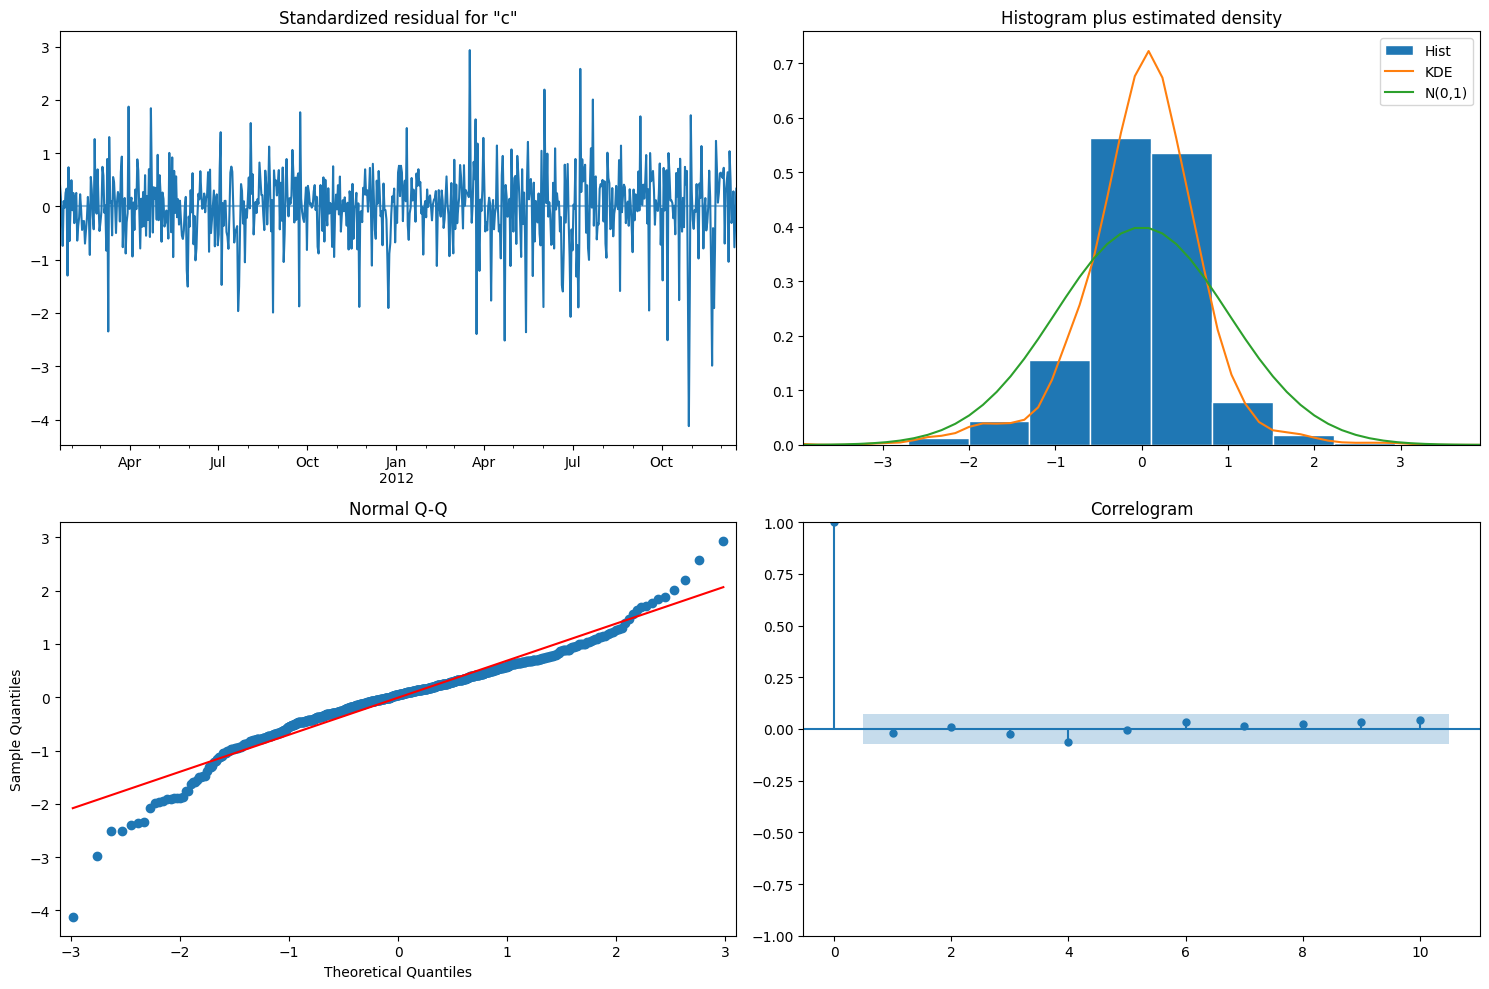


Residual Statistics:
Mean: -9.2887 (should be close to 0)
Std Dev: 742.4833
Min: -4359.9757
Max: 3102.0527

--------------------------------------------------------------------------------
Ljung-Box Test (Residual Autocorrelation):
--------------------------------------------------------------------------------
H0: Residuals are independently distributed (white noise)
If p-value > 0.05, residuals are white noise (good!)

     lb_stat  lb_pvalue
1   0.326184   0.567915
2   0.343376   0.842242
3   0.574287   0.902293
4   3.715253   0.445911
5   3.723350   0.589893
6   4.966402   0.548130
7   5.040628   0.655005
8   5.322450   0.722621
9   6.018575   0.738058
10  7.107203   0.715287

--------------------------------------------------------------------------------
Normality Tests:
--------------------------------------------------------------------------------
Jarque-Bera Test: statistic=437.5528, p-value=0.0000
Shapiro-Wilk Test: statistic=0.9489, p-value=0.0000
If p-value > 0.05, residu

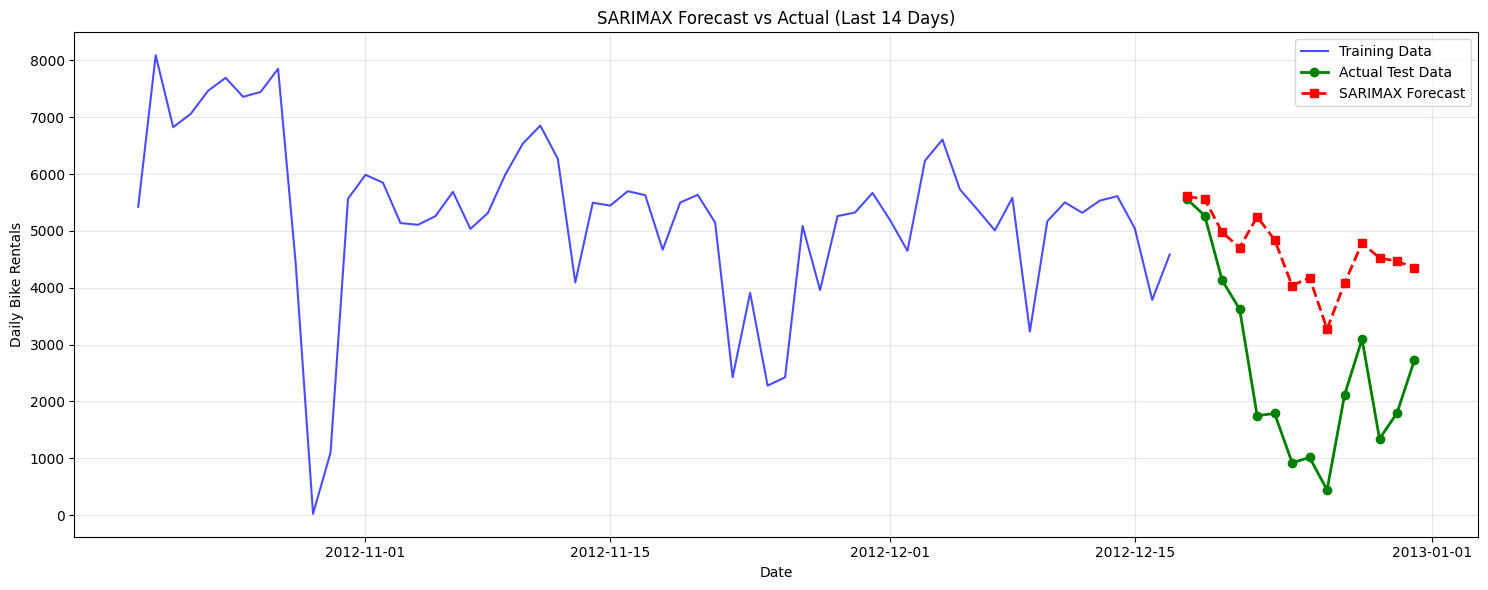

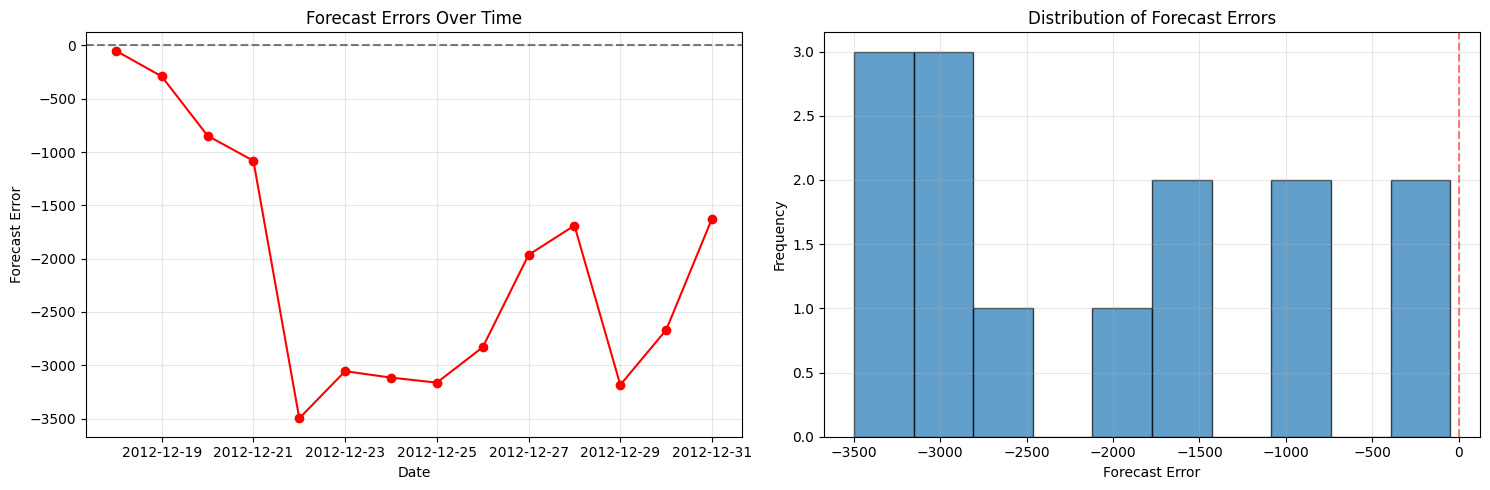

In [82]:
# Split data: last 14 days for testing
train_size = len(ts_cnt) - 14
ts_train = ts_cnt[:train_size]
ts_test = ts_cnt[train_size:]

print(f"\nTraining set size: {len(ts_train)}")
print(f"Testing set size: {len(ts_test)}")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ts_cnt.diff().dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(ts_cnt.diff().dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("SARIMAX Parameter Selection:")
print("-"*80)
print("""
Using SARIMAX(2, 1, 2)(1, 1, 1, 7) with exogenous variables:
- (p, d, q) = (2, 1, 2): Non-seasonal ARIMA components
- (P, D, Q, s) = (1, 1, 1, 7): Seasonal components with weekly period
- Exogenous variables: temp, humidity, windspeed, workingday, holiday, weather
""")

# Prepare exogenous variables
exog_train = df_day[:train_size][['temp', 'hum', 'windspeed', 
                                   'workingday', 'holiday', 'weathersit']]
exog_test = df_day[train_size:][['temp', 'hum', 'windspeed', 
                                  'workingday', 'holiday', 'weathersit']]

# Fit SARIMAX
print("\nFitting SARIMAX model...")
sarimax_model = SARIMAX(ts_train,
                        exog=exog_train,
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_fitted = sarimax_model.fit(disp=False)

# Make predictions with exogenous variables
sarimax_forecast = sarimax_fitted.forecast(steps=14, exog=exog_test)

print("\n" + "="*80)
print("SARIMAX Model Summary:")
print("="*80)
print(sarimax_fitted.summary())  # CORRECTED: Use fitted object

# ============================================================================
# COMPREHENSIVE DIAGNOSTICS
# ============================================================================

print("\n" + "="*80)
print("Model Diagnostics:")
print("="*80)

# 1. Plot built-in diagnostics
fig = sarimax_fitted.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

# 2. Residual Analysis
residuals = sarimax_fitted.resid

print("\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f} (should be close to 0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

# 3. Ljung-Box Test (tests if residuals are white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print("\n" + "-"*80)
print("Ljung-Box Test (Residual Autocorrelation):")
print("-"*80)
print("H0: Residuals are independently distributed (white noise)")
print("If p-value > 0.05, residuals are white noise (good!)\n")
print(lb_test)

# 4. Normality Test
from scipy.stats import jarque_bera, shapiro

jb_stat, jb_pvalue = jarque_bera(residuals)
shapiro_stat, shapiro_pvalue = shapiro(residuals)

print("\n" + "-"*80)
print("Normality Tests:")
print("-"*80)
print(f"Jarque-Bera Test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk Test: statistic={shapiro_stat:.4f}, p-value={shapiro_pvalue:.4f}")
print("If p-value > 0.05, residuals are normally distributed (good!)")

# 5. Information Criteria
print("\n" + "-"*80)
print("Model Selection Criteria:")
print("-"*80)
print(f"AIC (Akaike Information Criterion): {sarimax_fitted.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {sarimax_fitted.bic:.2f}")
print(f"HQIC (Hannan-Quinn Criterion): {sarimax_fitted.hqic:.2f}")
print("Lower values indicate better model fit")

# ============================================================================
# FORECAST EVALUATION
# ============================================================================

print("\n" + "="*80)
print("Forecast Evaluation:")
print("="*80)

# Calculate metrics
sarimax_mae = mean_absolute_error(ts_test, sarimax_forecast)
sarimax_rmse = np.sqrt(mean_squared_error(ts_test, sarimax_forecast))
sarimax_mape = np.mean(np.abs((ts_test - sarimax_forecast) / ts_test)) * 100

print(f"\nSARIMAX MAE: {sarimax_mae:.4f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.4f}")
print(f"SARIMAX MAPE: {sarimax_mape:.2f}%")

# Plot forecast vs actual
plt.figure(figsize=(15, 6))
plt.plot(ts_train.index[-60:], ts_train[-60:], label='Training Data', color='blue', alpha=0.7)
plt.plot(ts_test.index, ts_test, label='Actual Test Data', color='green', linewidth=2, marker='o')
plt.plot(ts_test.index, sarimax_forecast, label='SARIMAX Forecast', 
         color='red', linewidth=2, linestyle='--', marker='s')
plt.xlabel('Date')
plt.ylabel('Daily Bike Rentals')
plt.title('SARIMAX Forecast vs Actual (Last 14 Days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot forecast errors
forecast_errors = ts_test - sarimax_forecast
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(ts_test.index, forecast_errors, marker='o', color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Forecast Error')
plt.title('Forecast Errors Over Time')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(forecast_errors, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Forecast Error')
plt.ylabel('Frequency')
plt.title('Distribution of Forecast Errors')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



We were able to lower ARIMA's MAE and MSE by a couple hundred, and SARIMAX yielded SARIMAX MAE: 2076.1627 SARIMAX RMSE: 2358.9051. This is a much better improvement, and looking at the SARIMAX forecasted valued they actually match the dips of the actual test data much better than our earlier more naive approach.

This is the final comparison between our naive NN, naive ARIMA, optimized NN, and season capable SARIMAX.

Naive NN:
- Test MSE: 60419.5547
- Test MAE: 171.5758
- Test R² Score: -0.8614

Optimized NN:
- Test MSE: 3402.6157
- Test MAE: 36.1279
- Test R² Score: 0.8952

Naive ARIMA:
- ARIMA RMSE: 2962.7155
- ARIMA MAE: 2642.2918

SARIMAX:
- SARIMAX RMSE: 2358.9051
- SARIMAX MAE: 2076.1627

Neural nets can perform really strongly given enough data, and the right architecture, however you need to know how to tweak the layers and that takes time and risk of overfitting. Also, I'd say the biggest con of a neural net is that they lack interpretability when compared to ARIMA/SARIMAX.

ARIMA/SARIMAX models have parameters that explain what is going on in the model and this means they have high interpretability.
However, ARIMA on its own can't capture the seasonality in the data which SARIMAX makes up for, although it is in a structured predefined way. This limits SARIMAX at times when there are random spikes or non-linear effects in the data.

They both have their strengths and weaknesses so I can't say one is better than the other. However, in this context for prediction power and forecasting I'd choose the neural net. If I were to explain why bike rentals have seasonality I'd choose ARIMA models.